### 경로 데이터 불러오기 / 보간

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

filenames = []
# CSV 파일에서 경로 데이터를 추출하는 함수
def extract_lat_lng_from_csv(directory):
    all_lat_lng_lists = []


    
    file_count = 0
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            filenames.append(filename)
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            lat_lng_list = [(row['lat'], row['lng']) for index, row in df.iterrows()]
            all_lat_lng_lists.append(lat_lng_list)
    return all_lat_lng_lists

 
# 경로 데이터를 읽어오는 경로 설정
directory_path = "./어디쉐어/어디쉐어 dbscan"
lat_lng_values = extract_lat_lng_from_csv(directory_path)
# # 보간된 경로 벡터들
# path_vectors = np.array([path for path in lat_lng_values])
# path_vectors

### 경로 데이터 시각화 (입력 데이터)

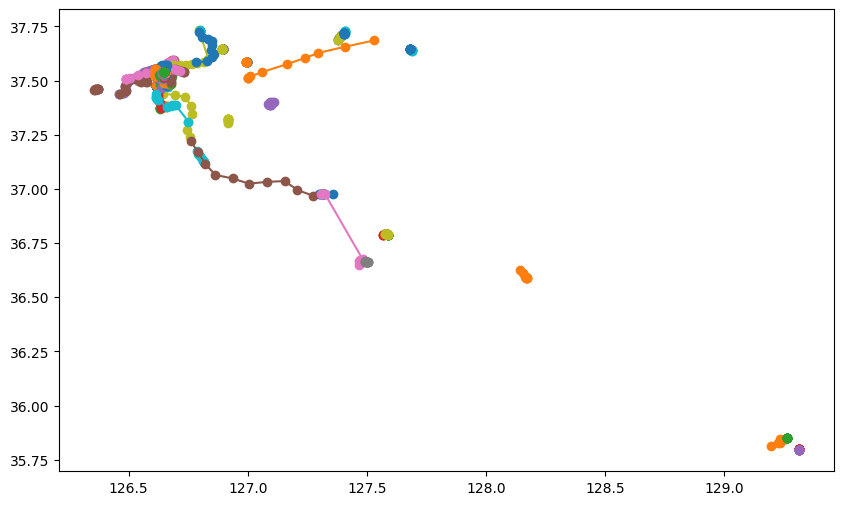

In [2]:
# 경로 벡터 시각화
plt.figure(figsize=(10, 6))

for i, path in enumerate(path_vectors):
    latitudes = path[::2]  # 짝수 인덱스는 위도
    longitudes = path[1::2]  # 홀수 인덱스는 경도
    plt.plot(longitudes, latitudes, marker='o', label=f'Path {i+1}')

### DBSCAN 모델로 이상치 판단 및 시각화 (출력 데이터)

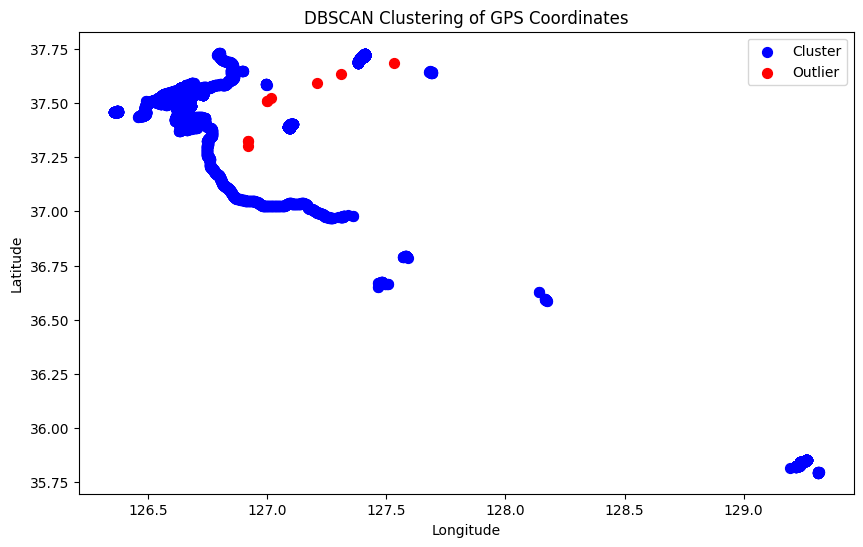

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Convert lat_lng_values into a 2D NumPy array
data = np.array([item for sublist in lat_lng_values for item in sublist])

# DBSCAN parameters
db = DBSCAN(eps=0.001, min_samples=5, metric='haversine').fit(np.radians(data))

# Extract labels (-1 indicates noise/outliers)
labels = db.labels_

# Plotting
plt.figure(figsize=(10, 6))
# Plot clusters (excluding outliers) - blue
plt.scatter(data[labels != -1, 1], data[labels != -1, 0], c='blue', s=50, label='Cluster')
# Plot outliers - red
plt.scatter(data[labels == -1, 1], data[labels == -1, 0], c='red', s=50, label='Outlier')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of GPS Coordinates')
plt.legend()
plt.show()


### 이상치 여부를 원본 CSV 파일에 기록

In [4]:
# 이상치 여부를 'dbscan output' 열에 기록하는 함수

def record_outliers(directory, labels, filenames):
 
    for label, filename in zip(labels, filenames):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        if 'dbscan output' not in df.columns:
            df['dbscan output'] = 1  # 기본값 1로 설정
        if label == -1:
            df['dbscan output'] = -1  # 이상치일 경우 -1로 설정
        df.to_csv(filepath, index=False)

# 이상치 여부를 CSV 파일에 기록
record_outliers(directory_path, labels, filenames)


### DBSCAN 이상경로 파일명 출력

In [4]:
# 이상경로 파일명을 텍스트로 출력하는 함수
def print_outlier_paths_with_filenames(labels, filenames):
    print('--------outlier_paths--------')
    for label, filename in zip(labels, filenames):
        if label == -1:
            print(filename)

# 이상경로 파일명을 텍스트로 출력
outlier_paths = print_outlier_paths_with_filenames(labels, filenames)


--------outlier_paths--------
20230429084545.csv
20230430160248.csv
20230430184009.csv
20230430190656.csv
20230430220837.csv
20230715132948.csv
20230715154101.csv
20230715194033.csv
20230716140812.csv
20230812122439.csv
20230812125121.csv
20230813201825.csv
20230814113500.csv
20230829192601.csv
20230910105144.csv
20231001111709.csv
20231001150901.csv
20231002105108.csv
20231003181802.csv
20231021173304.csv
20231202151537.csv
20231202171651.csv
20231202211845.csv
20231202230952.csv


## 비지도, 지도 비교를 위한 csv파일

### dbscan output을{inputdata} output.csv에 기록

In [9]:
import pandas as pd
import os

# 파일 경로 설정
output_file = '위드라이브user1 output.csv'

# 파일이 존재하는지 확인
if not os.path.isfile(output_file):
    raise FileNotFoundError(f"The file at {output_file} does not exist.")

# 파일 읽기 시도
try:
    df = pd.read_csv(output_file)
except pd.errors.EmptyDataError:
    print(f"The file at {output_file} is empty or does not contain valid CSV data.")
    df = pd.DataFrame()  # 빈 데이터프레임 생성
except Exception as e:
    print(f"An error occurred: {e}")
    df = pd.DataFrame()  # 빈 데이터프레임 생성

# 부족한 행 수 계산
missing_rows = len(labels) - len(df)

# 부족한 행이 있을 때
if missing_rows > 0:
    # 부족한 행을 데이터프레임에 추가
    additional_rows = pd.DataFrame(index=range(len(df), len(df) + missing_rows))
    df = pd.concat([df, additional_rows], ignore_index=True)


# 'DBSCAN output'이라는 열을 추가하고, 조건에 따라 값을 설정합니다.
df['DBSCAN output'] = ['N' if label != -1 else 'AN' for label in labels]

# 결과를 새로운 CSV 파일로 저장합니다.
df.to_csv(output_file, index=False)

print('success')


success


### DBSCAN, GRU output match판단 및 기록

In [8]:
import pandas as pd

# CSV 파일을 읽어옵니다.
output_file = '위드라이브user1 output.csv'

# 'match' 열을 추가하고, 조건에 따라 값을 설정합니다.
df['match'] = ['N' if gru == dbscan else 'AN' for gru, dbscan in zip(df['GRU output'], df['DBSCAN output'])]

# 변경된 내용을 원래 파일에 저장합니다.
df.to_csv(output_file, index=False)

print('success')

NameError: name 'outputfile_df' is not defined

### NM 빨간색으로 표시

In [ ]:
# import pandas as pd
# from openpyxl import load_workbook
# from openpyxl.styles import PatternFill


# # CSV 파일을 Excel 파일로 변환합니다.
# excel_filename = 'preprocessing 2.xlsx'
# df.to_excel(excel_filename, index=False)

# # Excel 파일을 불러옵니다.
# wb = load_workbook(excel_filename)
# ws = wb.active

# # 'match' 열의 값이 'NM'인 셀을 빨간색으로 변경합니다.
# fill_red = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

# match_column_index = df.columns.get_loc('match') + 1  # 1-based index for openpyxl

# for row in range(2, ws.max_row + 1):  # 2번째 행부터 끝까지
#     cell = ws.cell(row=row, column=match_column_index)
#     if cell.value == 'NM':
#         cell.fill = fill_red

# # 변경된 내용을 Excel 파일에 저장합니다.
# wb.save(excel_filename)

# print('success')

### 통계 정보 출력

In [ ]:
import pandas as pd

def print_statistics(col):
    # CSV 파일을 읽어옵니다.
    df = outputfile_df()
    
    total_rows = len(df)
    count_N = df[col].value_counts().get('N', 0)
    count_AN = df[col].value_counts().get('AN', 0)

    print(f'--------{col}--------')
    print(f'total {col} : {total_rows}')
    print(f'N in {col} : {count_N}')
    print(f'AN in {col} : {count_AN}')

print_statistics('GRU output')
print_statistics('DBSCAN output')
print_statistics('match')
